In [5]:
import core.vem as vem
from utils.mesh import unitary_square_mesh
import numpy as np

def f(c):
    return -np.sin(np.pi*c[0])*np.sin(np.pi*c[1])

nodes, elements = unitary_square_mesh(2)
supp = np.array([0, 1, 2, 3, 5, 6, 7, 8])

K = vem.buildGlobalPoisson(nodes, elements)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")


#################### Poisson #####################
[ 0.          0.          0.         ... 11.45927253 11.46566086
 11.4677962 ]
####################################################


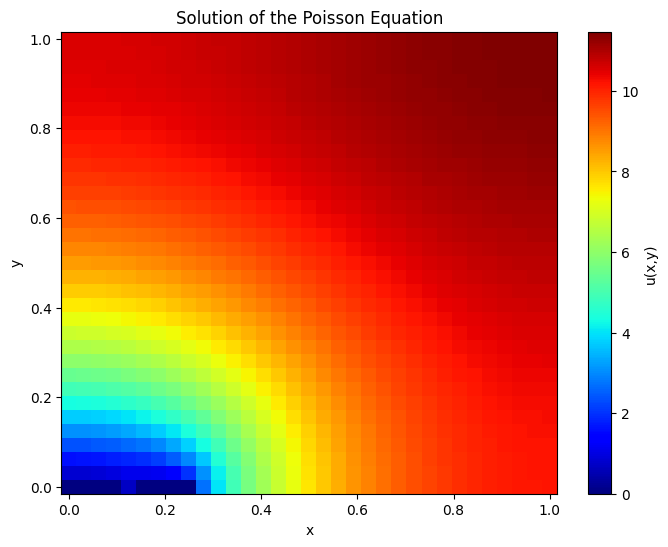

In [6]:
import matplotlib.pyplot as plt

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes)) - 1)  # Adjust based on your mesh size
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()